In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../predictions.csv')

In [3]:
from sklearn.preprocessing import MinMaxScaler

df['Normalized Observed'] = MinMaxScaler().fit_transform(df[['Observed log(TX/Txref)']])

In [4]:
df['Normalized Observed'] = df['Normalized Observed'].apply(lambda x: x * 10)

In [5]:
def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = []
    for nucleotide in sequence:
         encoding += [mapping[nucleotide]]
    return encoding


X = df[['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']]
y = df['Normalized Observed']

upstream_padding = {}
for col in X.columns:
    max_len = X[col].apply(len).max()
    upstream_padding[col] = np.array([padded_one_hot_encode('0' * (max_len - len(seq)) + seq) for seq in X[col]])

X = np.concatenate([upstream_padding[col] for col in X.columns], axis=1)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# stores the various input approaches
X_dict = {}

# stores split training/testing
train_test = {}

# stores the results
results = {}

# stores the models
models = {}

# stores the model history
model_history = {}

In [8]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Define CNN model architecture
models['CNN'] = Sequential()
models['CNN'].add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=X.shape[1:]))
models['CNN'].add(MaxPooling1D(pool_size=2))
models['CNN'].add(Conv1D(filters=64, kernel_size=3, activation='relu'))
models['CNN'].add(MaxPooling1D(pool_size=2))
models['CNN'].add(Flatten())
models['CNN'].add(Dense(64, activation='relu'))
models['CNN'].add(Dense(1, activation='linear'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
models['CNN'].compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

# Train the model
history = models['CNN'].fit(X_train,
                            y_train,
                            epochs=150,
                            batch_size=32,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping])

# Evaluate the model
loss = models['CNN'].evaluate(X_test, y_test)

results['CNN'] = loss
model_history['CNN'] = history
models['CNN'].save('CNN.keras')


c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.6875 - val_loss: 0.8609
Epoch 2/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8978 - val_loss: 0.7954
Epoch 3/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8131 - val_loss: 0.8895
Epoch 4/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7736 - val_loss: 0.7606
Epoch 5/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8059 - val_loss: 0.7844
Epoch 6/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7389 - val_loss: 0.7754
Epoch 7/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7602 - val_loss: 0.7402
Epoch 8/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7042 - val_loss: 0.7338
Epoch 9/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7074 - val_loss: 0.7658
Epoch 10/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.6979 - val_loss: 0.7259
Epoch 11/150
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6918 - val_loss: 0.7266
Epoch 12/150
334/334 ━━━━━━━━━━━━━━━━━━━━

In [9]:
print(loss)

0.693970263004303


In [10]:
our_prediction_dict = {}

for i in range(len(X)):
    our_prediction_dict[i] = models['CNN'].predict(np.array([X[i]]))[0][0]
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

In [11]:
our_prediction = pd.DataFrame.from_dict(our_prediction_dict, orient='index', columns=['Value'])
observed = df['Normalized Observed']

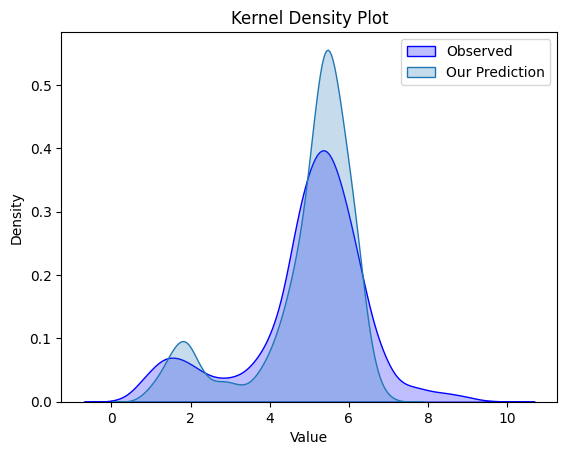

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(observed, fill=True, color='blue', label='Observed')
sns.kdeplot(our_prediction, fill=True, color='green', label='Our Prediction')

plt.title('Kernel Density Plot')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [13]:
observed.shape

(13341,)

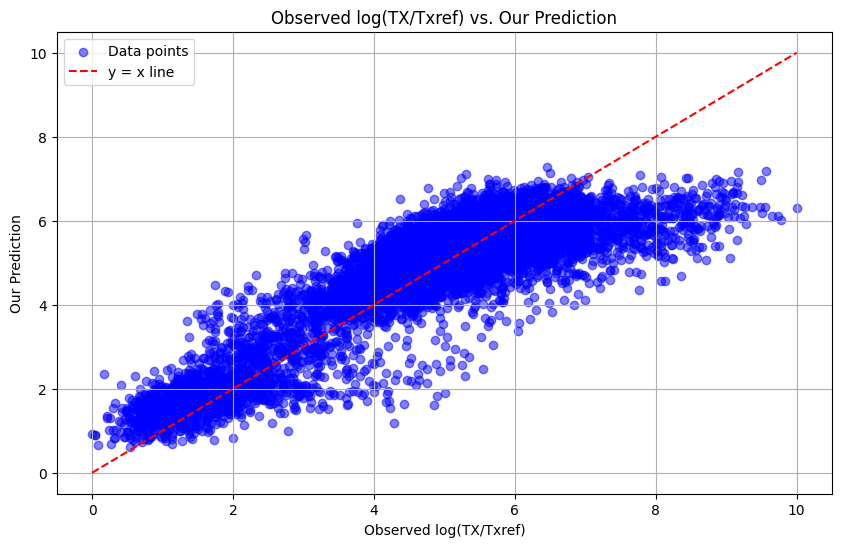

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `our_prediction` and `observed` are already defined
our_prediction = np.ravel(our_prediction)

plt.figure(figsize=(10, 6))
plt.scatter(observed, our_prediction, color='blue', alpha=0.5, label='Data points')

# Adding the y = x line
min_val = min(min(observed), min(our_prediction))
max_val = max(max(observed), max(our_prediction))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x line')

plt.title('Observed log(TX/Txref) vs. Our Prediction')
plt.xlabel('Observed log(TX/Txref)')
plt.ylabel('Our Prediction')
plt.legend()
plt.grid(True)
plt.show()
